In [4]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'


In [5]:
%pwd
%cd ..
%cd src
%pwd

/home/kyudan/AnomLLM
/home/kyudan/AnomLLM/src


'/home/kyudan/AnomLLM/src'

In [6]:
#Please edit the BASE_DIR on your situation.

BASE_DIR = "/home/kyudan/AnomLLM"

In [7]:
def sample_time_series(time_series, num_samples):
    values = time_series.split()
    
    # 앞에서부터 num_samples개만 선택
    sampled_values = values[:num_samples]
    
    # 인덱스, 숫자 형식으로 변환
    formatted_samples = []
    for i, value in enumerate(sampled_values):
        formatted_samples.append(f"{i}, {value}")
    
    # 줄바꿈으로 구분하여 반환
    return "\n".join(formatted_samples)


def make_component_prompt_with_sample(time_series, num_samples):
    """
    원하는 샘플 수로 시계열을 샘플링하고 해당 길이에 맞는 프롬프트를 생성합니다.
    
    Args:
        time_series (str): 원본 시계열 데이터 문자열
        num_samples (int): 실험에 사용할 샘플 수 (100, 200, 300 등)
    
    Returns:
        str: 트렌드 컴포넌트 추출을 위한 프롬프트
    """
    # 앞에서부터 원하는 샘플 수만큼만 추출
    sampled_series = sample_time_series(time_series, num_samples)
    
    # 프롬프트 생성
    COMPONENT_PROMPT = f"""Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
{sampled_series}

CRITICAL INSTRUCTION: Extract ONLY the trend component from this time series.

EXACT LENGTH REQUIREMENT: Your output MUST contain EXACTLY {num_samples} values - one trend value for EACH value in the original time series.

DECIMAL PRECISION: Maintain the same level of precision as the original data (2 decimal places). Example: If original values are like "-0.63", "-0.57", trend values should also have 2 decimal places like "-0.62", "-0.61".

Count the values in the original data carefully. The original has exactly {num_samples} values, so your trend component must also have exactly {num_samples} values, no more and no less.

Return your answer as space-separated numbers in the following JSON format:
{{
  "Trend": "value1 value2 value3 ... value{num_samples}"
}}

DO NOT abbreviate or shorten the output. Include EVERY single trend value with 2 decimal places.
"""
    return COMPONENT_PROMPT

In [8]:
from prompt import LIMIT_PROMPT,PROMPT, time_series_to_str


def create_component_prompt(
        idx,
        series,
        num_samples,
):

    messages = [
        {
            "role": "user",
            "content": make_component_prompt_with_sample(time_series_to_str(series[idx]), num_samples,)
        }
    ]
    if idx == 0:
        print(messages[0]["content"])
    return {
        "messages": messages,
        "temperature": 0.4,
        "stop": ["''''", " – –", "<|endoftext|>", "<|eot_id|>"]
    }


In [9]:
from openai_api import send_openai_request
import json
import time
import os
from loguru import logger
from data.synthetic import SyntheticDataset
import pandas as pd



def online_AD_with_retries_component(
    model_name: str,
    pcl_name: str,
    #data_name: str,
    #request_func: callable,
    #variant: str = "standard",
    num_retries: int = 4,
    num_samples: int = 100,
    restrict_to_10_samples: bool = False,
):
    df = pd.read_pickle(pcl_name)

    # Initialize dictionary to store results
    results = {}

    # Configure logger
    log_fn = f"logs/synthetic/{pcl_name}/{model_name}/" + ".log"
    logger.add(log_fn, format="{time} {level} {message}", level="INFO")
    results_dir = f'{BASE_DIR}/results/synthetic/{pcl_name}/{model_name}/'
    jsonl_fn = os.path.join(results_dir + f'component_2_num_samples_index-{num_samples}.jsonl')
    os.makedirs(results_dir, exist_ok=True)

    if os.path.exists(jsonl_fn):
        logger.error(f"Results file '{jsonl_fn}' already exists. Please delete it first to avoid duplicate entries.")
        print(f"Results file '{jsonl_fn}' already exists. Please delete it and run again.")
        return None

    for i in (range(1,11) if restrict_to_10_samples else range(1, len(df)+1)):
        custom_id = f"{pcl_name}_{model_name}_{str(i).zfill(5)}"
        series = df['series_values']

        # Perform anomaly detection with exponential backoff
        for attempt in range(num_retries):
            try:
                request = create_component_prompt(i-1, series, num_samples)
                start = time.time()
                response = send_openai_request(request, model_name)
                end = time.time()
                print(f"time: {end-start}")
                # Write the result to jsonl
                with open(jsonl_fn, 'a') as f:
                    json.dump({'custom_id': custom_id, 'request': request, 'response': response}, f)
                    f.write('\n')
                # If successful, break the retry loop
                break
            except Exception as e:
                if "503" in str(e):  # Server not up yet, sleep until the server is up again
                    while True:
                        logger.debug("503 error, sleep 30 seconds")
                        time.sleep(30)
                        try:
                            response = send_openai_request(request, model_name)
                            break
                        except Exception as e:
                            if "503" not in str(e):
                                break
                else:
                    logger.error(e)
                    # If an exception occurs, wait and then retry
                    wait_time = 2 ** (attempt + 3)
                    logger.debug(f"Attempt {attempt + 1} failed. Waiting for {wait_time} seconds before retrying...")
                    time.sleep(wait_time)
                    continue
        else:
            logger.error(f"Failed to process {custom_id} after {num_retries} attempts")

In [10]:
pcl_name = "../data/synthetic/component_series_400.pkl"
for num in [100,200,300,400,500,600,700,800,900,1000]:
    online_AD_with_retries_component('gemini-1.5-flash', pcl_name, num_samples=num, restrict_to_10_samples = True)


2025-04-11 23:26:16.954 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
0, -0.63
1, -0.57
2, -0.52
3, -0.47
4, -0.42
5, -0.38
6, -0.33
7, -0.3
8, -0.26
9, -0.24
10, -0.22
11, -0.2
12, -0.2
13, -0.19
14, -0.2
15, -0.21
16, -0.23
17, -0.25
18, -0.28
19, -0.32
20, -0.36
21, -0.4
22, -0.45
23, -0.5
24, -0.55
25, -0.6
26, -0.65
27, -0.7
28, -0.75
29, -0.79
30, -0.84
31, -0.88
32, -0.91
33, -0.94
34, -0.96
35, -0.98
36, -0.99
37, -1.0
38, -1.0
39, -0.99
40, -0.98
41, -0.96
42, -0.93
43, -0.9
44, -0.86
45, -0.82
46, -0.77
47, -0.72
48, -0.67
49, -0.62
50, -0.57
51, -0.51
52, -0.46
53, -0.41
54, -0.36
55, -0.31
56, -0.27
57, -0.23
58, -0.2
59, -0

2025-04-11 23:26:21.634 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 4.668553352355957


2025-04-11 23:26:26.359 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 4.72467303276062


2025-04-11 23:26:31.442 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 5.081388711929321


2025-04-11 23:26:36.670 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 5.226760625839233


2025-04-11 23:26:41.263 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 4.591704368591309


2025-04-11 23:26:46.962 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 5.689950227737427


2025-04-11 23:26:51.828 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 4.864645004272461


2025-04-11 23:26:56.719 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 4.889017105102539


2025-04-11 23:27:01.198 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 4.478754043579102


2025-04-11 23:27:06.604 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 5.369943141937256
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
0, -0.63
1, -0.57
2, -0.52
3, -0.47
4, -0.42
5, -0.38
6, -0.33
7, -0.3
8, -0.26
9, -0.24
10, -0.22
11, -0.2
12, -0.2
13, -0.19
14, -0.2
15, -0.21
16, -0.23
17, -0.25
18, -0.28
19, -0.32
20, -0.36
21, -0.4
22, -0.45
23, -0.5
24, -0.55
25, -0.6
26, -0.65
27, -0.7
28, -0.75
29, -0.79
30, -0.84
31, -0.88
32, -0.91
33, -0.94
34, -0.96
35, -0.98
36, -0.99
37, -1.0
38, -1.0
39, -0.99
40, -0.98
41, -0.96
42, -0.93
43, -0.9
44, -0.86
45, -0.82
46, -0.77
47, -0.72
48, -0.67
49, -0.62
50, -0.57
51, -0.51
52, -0.46
53, -0.41
54, -0.36
55, -0.31
56, -0.27
5

2025-04-11 23:27:15.668 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 9.063011407852173


2025-04-11 23:27:24.531 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 8.861027002334595


2025-04-11 23:27:33.522 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 8.990499496459961


2025-04-11 23:27:42.344 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 8.82031774520874


2025-04-11 23:27:51.176 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 8.830176830291748


2025-04-11 23:27:59.295 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 8.119073152542114


2025-04-11 23:28:07.072 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 7.7761359214782715


2025-04-11 23:28:16.146 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 9.073388576507568


2025-04-11 23:28:24.879 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 8.731604099273682


2025-04-11 23:28:34.030 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 9.133320331573486
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
0, -0.63
1, -0.57
2, -0.52
3, -0.47
4, -0.42
5, -0.38
6, -0.33
7, -0.3
8, -0.26
9, -0.24
10, -0.22
11, -0.2
12, -0.2
13, -0.19
14, -0.2
15, -0.21
16, -0.23
17, -0.25
18, -0.28
19, -0.32
20, -0.36
21, -0.4
22, -0.45
23, -0.5
24, -0.55
25, -0.6
26, -0.65
27, -0.7
28, -0.75
29, -0.79
30, -0.84
31, -0.88
32, -0.91
33, -0.94
34, -0.96
35, -0.98
36, -0.99
37, -1.0
38, -1.0
39, -0.99
40, -0.98
41, -0.96
42, -0.93
43, -0.9
44, -0.86
45, -0.82
46, -0.77
47, -0.72
48, -0.67
49, -0.62
50, -0.57
51, -0.51
52, -0.46
53, -0.41
54, -0.36
55, -0.31
56, -0.27
5

2025-04-11 23:28:46.990 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.959742307662964


2025-04-11 23:28:59.904 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.911981582641602


2025-04-11 23:29:12.868 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.963726043701172


2025-04-11 23:29:26.006 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.137118101119995


2025-04-11 23:29:39.130 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.123229026794434


2025-04-11 23:29:50.983 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 11.851306676864624


2025-04-11 23:30:03.921 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.93788456916809


2025-04-11 23:30:17.016 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.093464612960815


2025-04-11 23:30:29.622 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.605517864227295


2025-04-11 23:30:42.329 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.691259145736694
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
0, -0.63
1, -0.57
2, -0.52
3, -0.47
4, -0.42
5, -0.38
6, -0.33
7, -0.3
8, -0.26
9, -0.24
10, -0.22
11, -0.2
12, -0.2
13, -0.19
14, -0.2
15, -0.21
16, -0.23
17, -0.25
18, -0.28
19, -0.32
20, -0.36
21, -0.4
22, -0.45
23, -0.5
24, -0.55
25, -0.6
26, -0.65
27, -0.7
28, -0.75
29, -0.79
30, -0.84
31, -0.88
32, -0.91
33, -0.94
34, -0.96
35, -0.98
36, -0.99
37, -1.0
38, -1.0
39, -0.99
40, -0.98
41, -0.96
42, -0.93
43, -0.9
44, -0.86
45, -0.82
46, -0.77
47, -0.72
48, -0.67
49, -0.62
50, -0.57
51, -0.51
52, -0.46
53, -0.41
54, -0.36
55, -0.31
56, -0.27


2025-04-11 23:31:11.174 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 28.844268560409546


2025-04-11 23:31:39.990 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 28.814230918884277


2025-04-11 23:32:12.762 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 32.77199101448059


2025-04-11 23:32:41.509 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 28.745917320251465


2025-04-11 23:33:10.821 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 29.311161041259766


2025-04-11 23:33:26.102 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 15.27970266342163


2025-04-11 23:33:39.277 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.174322128295898


2025-04-11 23:34:08.029 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 28.75076198577881


2025-04-11 23:34:37.111 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 29.08171534538269


2025-04-11 23:34:53.081 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 15.956676483154297
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
0, -0.63
1, -0.57
2, -0.52
3, -0.47
4, -0.42
5, -0.38
6, -0.33
7, -0.3
8, -0.26
9, -0.24
10, -0.22
11, -0.2
12, -0.2
13, -0.19
14, -0.2
15, -0.21
16, -0.23
17, -0.25
18, -0.28
19, -0.32
20, -0.36
21, -0.4
22, -0.45
23, -0.5
24, -0.55
25, -0.6
26, -0.65
27, -0.7
28, -0.75
29, -0.79
30, -0.84
31, -0.88
32, -0.91
33, -0.94
34, -0.96
35, -0.98
36, -0.99
37, -1.0
38, -1.0
39, -0.99
40, -0.98
41, -0.96
42, -0.93
43, -0.9
44, -0.86
45, -0.82
46, -0.77
47, -0.72
48, -0.67
49, -0.62
50, -0.57
51, -0.51
52, -0.46
53, -0.41
54, -0.36
55, -0.31
56, -0.27


2025-04-11 23:35:05.751 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.669277667999268


2025-04-11 23:35:22.421 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 16.669503927230835


2025-04-11 23:35:41.999 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 19.576934099197388


2025-04-11 23:35:59.244 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 17.243820905685425


2025-04-11 23:36:13.063 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.817916870117188


2025-04-11 23:36:31.070 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 18.006938695907593


2025-04-11 23:36:44.620 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.547465085983276


2025-04-11 23:36:57.738 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.113150835037231


2025-04-11 23:37:10.655 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.917451620101929


2025-04-11 23:37:24.168 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.500576257705688
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
0, -0.63
1, -0.57
2, -0.52
3, -0.47
4, -0.42
5, -0.38
6, -0.33
7, -0.3
8, -0.26
9, -0.24
10, -0.22
11, -0.2
12, -0.2
13, -0.19
14, -0.2
15, -0.21
16, -0.23
17, -0.25
18, -0.28
19, -0.32
20, -0.36
21, -0.4
22, -0.45
23, -0.5
24, -0.55
25, -0.6
26, -0.65
27, -0.7
28, -0.75
29, -0.79
30, -0.84
31, -0.88
32, -0.91
33, -0.94
34, -0.96
35, -0.98
36, -0.99
37, -1.0
38, -1.0
39, -0.99
40, -0.98
41, -0.96
42, -0.93
43, -0.9
44, -0.86
45, -0.82
46, -0.77
47, -0.72
48, -0.67
49, -0.62
50, -0.57
51, -0.51
52, -0.46
53, -0.41
54, -0.36
55, -0.31
56, -0.27


2025-04-11 23:37:37.926 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.756440877914429


2025-04-11 23:37:50.760 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.833677053451538


2025-04-11 23:38:05.155 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 14.393303871154785


2025-04-11 23:38:19.109 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.95381498336792


2025-04-11 23:38:32.910 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.799906492233276


2025-04-11 23:38:47.259 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 14.348142385482788


2025-04-11 23:39:02.034 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 14.774645328521729


2025-04-11 23:39:16.041 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 14.005084991455078


2025-04-11 23:39:30.485 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 14.444030046463013


2025-04-11 23:39:44.154 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.650807619094849
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
0, -0.63
1, -0.57
2, -0.52
3, -0.47
4, -0.42
5, -0.38
6, -0.33
7, -0.3
8, -0.26
9, -0.24
10, -0.22
11, -0.2
12, -0.2
13, -0.19
14, -0.2
15, -0.21
16, -0.23
17, -0.25
18, -0.28
19, -0.32
20, -0.36
21, -0.4
22, -0.45
23, -0.5
24, -0.55
25, -0.6
26, -0.65
27, -0.7
28, -0.75
29, -0.79
30, -0.84
31, -0.88
32, -0.91
33, -0.94
34, -0.96
35, -0.98
36, -0.99
37, -1.0
38, -1.0
39, -0.99
40, -0.98
41, -0.96
42, -0.93
43, -0.9
44, -0.86
45, -0.82
46, -0.77
47, -0.72
48, -0.67
49, -0.62
50, -0.57
51, -0.51
52, -0.46
53, -0.41
54, -0.36
55, -0.31
56, -0.27


2025-04-11 23:39:57.888 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.733258485794067


2025-04-11 23:40:12.879 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 14.989734888076782


2025-04-11 23:40:27.290 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 14.410675764083862


2025-04-11 23:40:41.209 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.918195724487305


2025-04-11 23:40:55.968 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 14.757599592208862


2025-04-11 23:41:09.096 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.126965045928955


2025-04-11 23:41:23.208 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 14.111454248428345


2025-04-11 23:41:36.629 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.419925451278687


2025-04-11 23:41:51.049 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 14.419439792633057


2025-04-11 23:42:05.373 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 14.312374353408813
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
0, -0.63
1, -0.57
2, -0.52
3, -0.47
4, -0.42
5, -0.38
6, -0.33
7, -0.3
8, -0.26
9, -0.24
10, -0.22
11, -0.2
12, -0.2
13, -0.19
14, -0.2
15, -0.21
16, -0.23
17, -0.25
18, -0.28
19, -0.32
20, -0.36
21, -0.4
22, -0.45
23, -0.5
24, -0.55
25, -0.6
26, -0.65
27, -0.7
28, -0.75
29, -0.79
30, -0.84
31, -0.88
32, -0.91
33, -0.94
34, -0.96
35, -0.98
36, -0.99
37, -1.0
38, -1.0
39, -0.99
40, -0.98
41, -0.96
42, -0.93
43, -0.9
44, -0.86
45, -0.82
46, -0.77
47, -0.72
48, -0.67
49, -0.62
50, -0.57
51, -0.51
52, -0.46
53, -0.41
54, -0.36
55, -0.31
56, -0.27


2025-04-11 23:42:22.484 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 17.109556913375854


2025-04-11 23:42:39.726 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 17.241374969482422


2025-04-11 23:42:58.820 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 19.092973470687866


2025-04-11 23:43:12.209 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.388142347335815


2025-04-11 23:43:29.389 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 17.178986072540283


2025-04-11 23:43:44.949 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 15.558487892150879


2025-04-11 23:43:59.855 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 14.9056236743927


2025-04-11 23:44:18.119 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 18.262747764587402


2025-04-11 23:44:32.200 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 14.079587459564209


2025-04-11 23:44:49.745 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 17.53414535522461
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
0, -0.63
1, -0.57
2, -0.52
3, -0.47
4, -0.42
5, -0.38
6, -0.33
7, -0.3
8, -0.26
9, -0.24
10, -0.22
11, -0.2
12, -0.2
13, -0.19
14, -0.2
15, -0.21
16, -0.23
17, -0.25
18, -0.28
19, -0.32
20, -0.36
21, -0.4
22, -0.45
23, -0.5
24, -0.55
25, -0.6
26, -0.65
27, -0.7
28, -0.75
29, -0.79
30, -0.84
31, -0.88
32, -0.91
33, -0.94
34, -0.96
35, -0.98
36, -0.99
37, -1.0
38, -1.0
39, -0.99
40, -0.98
41, -0.96
42, -0.93
43, -0.9
44, -0.86
45, -0.82
46, -0.77
47, -0.72
48, -0.67
49, -0.62
50, -0.57
51, -0.51
52, -0.46
53, -0.41
54, -0.36
55, -0.31
56, -0.27
5

2025-04-11 23:45:11.549 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 21.803311824798584


2025-04-11 23:45:33.146 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 21.596115350723267


2025-04-11 23:45:54.965 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 21.817208766937256


2025-04-11 23:46:17.284 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 22.31886601448059


2025-04-11 23:46:39.880 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 22.593960523605347


2025-04-11 23:47:12.162 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 32.28196477890015


2025-04-11 23:47:33.622 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 21.459059238433838


2025-04-11 23:47:54.336 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 20.713102340698242


2025-04-11 23:48:14.689 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 20.351566553115845


2025-04-11 23:48:36.723 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 22.023176670074463
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
0, -0.63
1, -0.57
2, -0.52
3, -0.47
4, -0.42
5, -0.38
6, -0.33
7, -0.3
8, -0.26
9, -0.24
10, -0.22
11, -0.2
12, -0.2
13, -0.19
14, -0.2
15, -0.21
16, -0.23
17, -0.25
18, -0.28
19, -0.32
20, -0.36
21, -0.4
22, -0.45
23, -0.5
24, -0.55
25, -0.6
26, -0.65
27, -0.7
28, -0.75
29, -0.79
30, -0.84
31, -0.88
32, -0.91
33, -0.94
34, -0.96
35, -0.98
36, -0.99
37, -1.0
38, -1.0
39, -0.99
40, -0.98
41, -0.96
42, -0.93
43, -0.9
44, -0.86
45, -0.82
46, -0.77
47, -0.72
48, -0.67
49, -0.62
50, -0.57
51, -0.51
52, -0.46
53, -0.41
54, -0.36
55, -0.31
56, -0.27


2025-04-11 23:48:52.406 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 15.68221926689148


2025-04-11 23:49:08.114 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 15.70558786392212


2025-04-11 23:49:23.406 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 15.29208779335022


2025-04-11 23:49:39.711 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 16.30379605293274


2025-04-11 23:49:54.868 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 15.15571117401123


2025-04-11 23:50:16.387 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 21.51867914199829


2025-04-11 23:50:37.470 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 21.08147382736206


2025-04-11 23:50:53.197 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 15.726184606552124


2025-04-11 23:51:06.871 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.672865152359009
time: 13.844049215316772


In [16]:
%pwd

'/home/kyudan/AnomLLM/src'

10개의 파일을 찾았습니다
component_2_num_samples_index-900.jsonl 처리 중 (총 10개 라인)
입력 데이터 개수: 900
출력 데이터 개수 - 평균: 592.40, 최소: 564, 최대: 845
----------------------------------------
component_2_num_samples_index-700.jsonl 처리 중 (총 10개 라인)
입력 데이터 개수: 700
출력 데이터 개수 - 평균: 360.40, 최소: 325, 최대: 367
----------------------------------------
component_2_num_samples_index-300.jsonl 처리 중 (총 10개 라인)
입력 데이터 개수: 300
출력 데이터 개수 - 평균: 361.90, 최소: 344, 최대: 366
----------------------------------------
component_2_num_samples_index-800.jsonl 처리 중 (총 10개 라인)
입력 데이터 개수: 800
출력 데이터 개수 - 평균: 430.40, 최소: 364, 최대: 464
----------------------------------------
component_2_num_samples_index-1000.jsonl 처리 중 (총 10개 라인)
입력 데이터 개수: 1000
출력 데이터 개수 - 평균: 398.90, 최소: 363, 최대: 545
----------------------------------------
component_2_num_samples_index-400.jsonl 처리 중 (총 10개 라인)
입력 데이터 개수: 400
출력 데이터 개수 - 평균: 742.40, 최소: 367, 최대: 964
----------------------------------------
component_2_num_samples_index-100.jsonl 처리 중 (총 10개 라인)
입력 데이터 개수

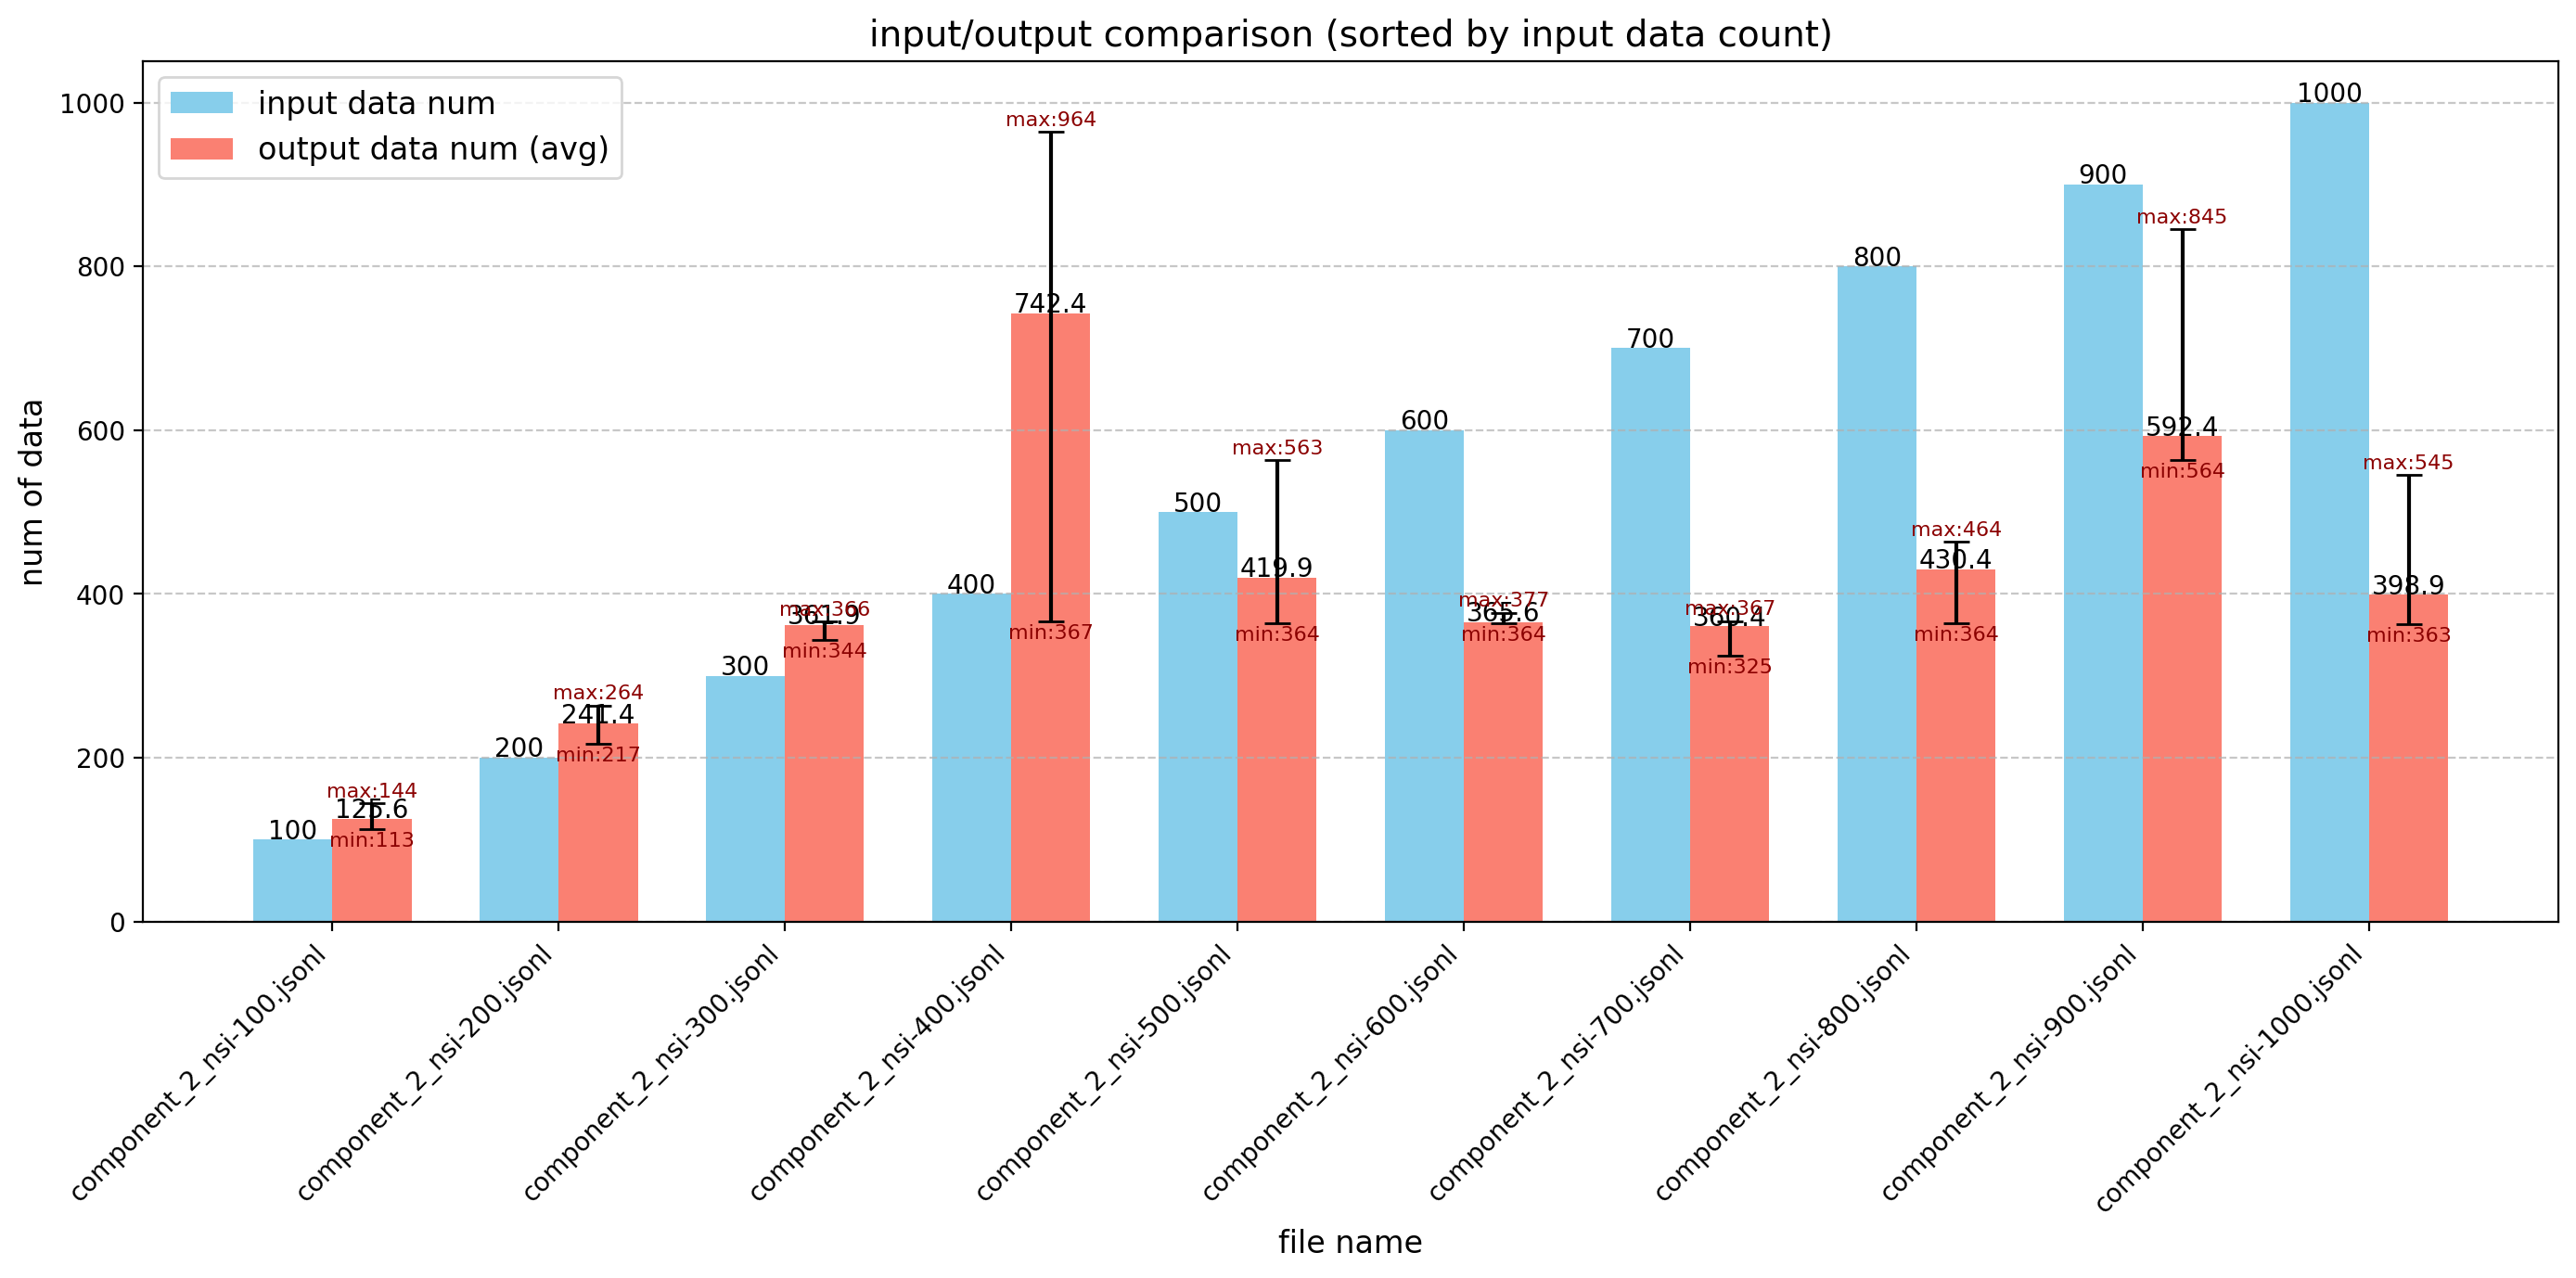


결과가 'data_count_results_sorted.json'과 'data_count_comparison_sorted.png'에 저장되었습니다


In [22]:
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# 1. 'gemini-1.5-flash' 디렉토리에서 'num_samples_index'가 포함된 jsonl 파일 찾기
file_pattern = os.path.join('/home/kyudan/AnomLLM/results/data/synthetic/component_series_400.pkl/gemini-1.5-flash'
                            , '*num_samples_index*.jsonl')
jsonl_files = glob(file_pattern)

if not jsonl_files:
    print(f"패턴 {file_pattern}에 맞는 파일이 없습니다")
    exit(1)

print(f"{len(jsonl_files)}개의 파일을 찾았습니다")

# 결과를 저장할 딕셔너리
results = {
    'filenames': [],
    'input_data_counts': [],
    'output_data_counts_avg': [],
    'output_data_counts_min': [],
    'output_data_counts_max': []
}

# 2. 각 파일에 대해 처리
for jsonl_file in jsonl_files:
    filename = os.path.basename(jsonl_file)
    results['filenames'].append(filename)
    
    input_data_counts = []
    output_data_counts = []
    
    # 파일 내용 읽기
    with open(jsonl_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    print(f"{filename} 처리 중 (총 {len(lines)}개 라인)")
    
    # 각 라인(JSON 객체) 처리
    for line_idx, line in enumerate(lines):
        try:
            data = json.loads(line.strip())
            
            # request 필드의 messages 중 user 역할의 메시지 찾기
            if 'request' in data and 'messages' in data['request']:
                user_messages = [msg for msg in data['request']['messages'] if msg['role'] == 'user']
                if user_messages:
                    content = user_messages[0]['content']
                    
                    # "Below is the given time series data" 이후의 데이터 추출
                    match = re.search(r"Below is the given time series data:([\s\S]*?)(?:CRITICAL INSTRUCTION:|$)", 
                                    content, re.DOTALL)
                    
                    if match:
                        time_series_text = match.group(1).strip()
                        # 입력 데이터 라인 개수 계산 (형식: "인덱스, 값")
                        time_series_lines = [line.strip() for line in time_series_text.split('\n') 
                                           if line.strip() and re.match(r'^\d+,\s*-?\d+(\.\d+)?$', line.strip())]
                        input_data_count = len(time_series_lines)
                        input_data_counts.append(input_data_count)
            
            # response 필드에서 JSON 추출
            if 'response' in data:
                response_text = data['response']
                # JSON 코드 블록 추출
                json_match = re.search(r'```json\s*(.+?)\s*```', response_text, re.DOTALL)
                if json_match:
                    json_text = json_match.group(1)
                    try:
                        response_data = json.loads(json_text)
                        if 'Trend' in response_data:
                            # 공백으로 구분된 값 개수 세기
                            trend_values = response_data['Trend'].split()
                            output_data_count = len(trend_values)
                            output_data_counts.append(output_data_count)
                    except json.JSONDecodeError:
                        print(f"라인 {line_idx}의 JSON 파싱 오류: {json_text[:50]}...")
        except Exception as e:
            print(f"{filename}의 라인 {line_idx} 처리 중 오류: {e}")
            continue
    
    # 파일별 평균, 최소값, 최대값 계산
    if input_data_counts:
        # 모든 파일의 입력 데이터 개수는 동일하다고 했으므로 첫 번째 값 사용
        results['input_data_counts'].append(input_data_counts[0])
        print(f"입력 데이터 개수: {input_data_counts[0]}")
    else:
        results['input_data_counts'].append(0)
        print("입력 데이터를 찾을 수 없습니다!")
        
    if output_data_counts:
        avg_output_count = np.mean(output_data_counts)
        min_output_count = np.min(output_data_counts)
        max_output_count = np.max(output_data_counts)
        
        results['output_data_counts_avg'].append(avg_output_count)
        results['output_data_counts_min'].append(min_output_count)
        results['output_data_counts_max'].append(max_output_count)
        
        print(f"출력 데이터 개수 - 평균: {avg_output_count:.2f}, 최소: {min_output_count}, 최대: {max_output_count}")
    else:
        results['output_data_counts_avg'].append(0)
        results['output_data_counts_min'].append(0)
        results['output_data_counts_max'].append(0)
        print("출력 데이터를 찾을 수 없습니다!")
    
    print("-" * 40)

# 입력/출력 데이터 개수가 있는 파일만 필터링
valid_indices = [i for i, (inp, out) in enumerate(zip(results['input_data_counts'], results['output_data_counts_avg'])) 
                if inp > 0 and out > 0]

filtered_results = {
    'filenames': [results['filenames'][i] for i in valid_indices],
    'input_data_counts': [results['input_data_counts'][i] for i in valid_indices],
    'output_data_counts_avg': [results['output_data_counts_avg'][i] for i in valid_indices],
    'output_data_counts_min': [results['output_data_counts_min'][i] for i in valid_indices],
    'output_data_counts_max': [results['output_data_counts_max'][i] for i in valid_indices]
}

# 유효한 결과가 없으면 종료
if not filtered_results['filenames']:
    print("유효한 데이터가 없습니다")
    exit(1)

# 데이터를 입력 데이터 개수에 따라 정렬
sorted_indices = sorted(range(len(filtered_results['input_data_counts'])), 
                        key=lambda i: filtered_results['input_data_counts'][i])

sorted_results = {
    'filenames': [filtered_results['filenames'][i] for i in sorted_indices],
    'input_data_counts': [filtered_results['input_data_counts'][i] for i in sorted_indices],
    'output_data_counts_avg': [filtered_results['output_data_counts_avg'][i] for i in sorted_indices],
    'output_data_counts_min': [filtered_results['output_data_counts_min'][i] for i in sorted_indices],
    'output_data_counts_max': [filtered_results['output_data_counts_max'][i] for i in sorted_indices]
}

# 3. 결과 요약 출력
print("\n요약:")
for i, filename in enumerate(sorted_results['filenames']):
    print(f"{filename}: 입력 개수 = {sorted_results['input_data_counts'][i]}, " + 
          f"출력 개수 - 평균: {sorted_results['output_data_counts_avg'][i]:.2f}, " +
          f"최소: {sorted_results['output_data_counts_min'][i]}, " +
          f"최대: {sorted_results['output_data_counts_max'][i]}")

# 4. matplotlib으로 그래프 그리기
plt.figure(figsize=(14, 7))
x = np.arange(len(sorted_results['filenames']))
width = 0.35

# 입력 데이터 막대
bars1 = plt.bar(x - width/2, sorted_results['input_data_counts'], width, label='input data num', color='skyblue')

# 출력 데이터 막대
bars2 = plt.bar(x + width/2, sorted_results['output_data_counts_avg'], width, label='output data num (avg)', color='salmon')

# 오차 막대 추가 (최소값에서 최대값까지의 범위)
yerr_low = [avg - min_val for avg, min_val in zip(sorted_results['output_data_counts_avg'], sorted_results['output_data_counts_min'])]
yerr_high = [max_val - avg for avg, max_val in zip(sorted_results['output_data_counts_avg'], sorted_results['output_data_counts_max'])]
plt.errorbar(x + width/2, sorted_results['output_data_counts_avg'], yerr=[yerr_low, yerr_high], 
             fmt='none', ecolor='black', capsize=5)

# 막대 위에 값 표시
for i, v in enumerate(sorted_results['input_data_counts']):
    plt.text(i - width/2, v + 1, str(int(v)), ha='center')
    
for i, v in enumerate(sorted_results['output_data_counts_avg']):
    plt.text(i + width/2, v + 1, f"{v:.1f}", ha='center')
    
    # 최소값과 최대값 표시
    min_val = sorted_results['output_data_counts_min'][i]
    max_val = sorted_results['output_data_counts_max'][i]
    if min_val != max_val:  # 최소값과 최대값이 다를 경우에만 표시
        plt.text(i + width/2, min_val - 3, f"min:{min_val}", ha='center', va='top', fontsize=8, color='darkred')
        plt.text(i + width/2, max_val + 3, f"max:{max_val}", ha='center', va='bottom', fontsize=8, color='darkred')

plt.xlabel('file name', fontsize=12)
plt.ylabel('num of data', fontsize=12)
plt.title('input/output comparison (sorted by input data count)', fontsize=14)

# x축 레이블 가독성 향상
file_labels = [f.replace('num_samples_index', 'nsi') for f in sorted_results['filenames']]
plt.xticks(x, file_labels, rotation=45, ha='right')

plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('data_count_comparison_sorted.png', dpi=300)
plt.show()

# 5. 결과 JSON 파일로 저장
output_data = {
    'filenames': sorted_results['filenames'],
    'input_data_counts': [int(x) for x in sorted_results['input_data_counts']],
    'output_data_counts_avg': [float(x) for x in sorted_results['output_data_counts_avg']],
    'output_data_counts_min': [int(x) for x in sorted_results['output_data_counts_min']],
    'output_data_counts_max': [int(x) for x in sorted_results['output_data_counts_max']]
}

with open('data_count_results_sorted.json', 'w') as f:
    json.dump(output_data, f, indent=2)

print("\n결과가 'data_count_results_sorted.json'과 'data_count_comparison_sorted.png'에 저장되었습니다")